## Spike sorting outputs

[_Kilosort4_](https://github.com/mouseland/kilosort) and the __ecephys_pipeline__ uses [__phy__](link_to_phy) format which is a common format for sorting outputs. 

The __phy__ format is a set of __.npy__ and __.tsv__/__.csv__ files. Some of the files are:

 - ``spike_times.npy`` time in sample of each detected spike [n_spikes] 
 - ``spike_clusters.npy`` cluster each spike belongs to [n_spikes] 
 - ``amplitudes.npy`` amplitude of each spike [n_spikes] 
 - ``spike_templates.npy`` template used to fit each spike [n_spikes] 
 - ``pc_features.npy`` principal component features for each [n_spikes x nfeatures] 
 - ``pc_features_ind.npy`` principal component features for each [n_spikes x nfeatures] 
 - ``whitening_mat_inv.npy`` inverted whitening matrix
 -  ``channel_map.npy`` the indices of the channels in the raw data [n_channels]
 -  ``channel_positions.npy`` the X Y position of each channel [n_channels x 2]
 - ``mean_waveforms.npy`` average waveforms for each cluster [n_clusters x channels x samples]

There are some differences between the default output from _kilosort4_ and the _ecephys_pipeline_. The later includes __spike_positions.npy__, __metrics__ and __waveforms__.

In [13]:
from pathlib import Path
import numpy as np # to load the npy files
import pandas as pd # load tsv files
from helpers import *
import pylab as plt
outfolder = Path('./data/AL032_out/')

# we load the results in a dictionary so we don't accidentally confuse results from different sessions
res = dict(
    # spiketimes and other
    spike_times = np.load(outfolder.rglob('spike_times.npy').__next__()),
    spike_clusters = np.load(outfolder.rglob('spike_clusters.npy').__next__()),
    spike_templates = np.load(outfolder.rglob('spike_templates.npy').__next__()),
    pc_features = np.load(outfolder.rglob('pc_features.npy').__next__()),
    pc_feature_ind = np.load(outfolder.rglob('pc_feature_ind.npy').__next__()),
    spike_template_amplitudes = np.load(outfolder.rglob('amplitudes.npy').__next__()),
    # metrics for each cluster
    metrics = pd.read_csv(outfolder.rglob('metrics.csv').__next__()),
    # waveforms
    channel_indices = np.load(outfolder.rglob('channel_map.npy').__next__()),
    channel_positions = np.load(outfolder.rglob('channel_positions.npy').__next__()),
    mean_waveforms = np.load(outfolder.rglob('mean_waveforms.npy').__next__()),
    templates = np.load(outfolder.rglob('templates.npy').__next__()),
    whitening_mat_inv = np.load(outfolder.rglob('whitening_mat_inv.npy').__next__())
)

# estimate the amplitudes from the template fitting
res['spike_amplitudes'] = compute_spike_amplitudes(templates = res['templates'],
                                                   whitening_matrix= res['whitening_mat_inv'],
                                                   spike_templates = res['spike_templates'],
                                                   spike_template_amplitudes = res['spike_template_amplitudes'],
                                                   channel_positions = res['channel_positions'])
# estimate the positions from the template fitting features
res['spike_positions'] = estimate_spike_positions_from_features(spike_templates=res['spike_templates'],
                                       spike_pc_features = res['pc_features'],
                                       template_pc_features_ind = res['pc_feature_ind'],
                                       channel_positions = res['channel_positions'])
                                       

In [14]:
res = load_phy_folder(outfolder) # this is converted to a function in the helpers

In [15]:
# make sure that the shapes are the ones we expect
for k in res.keys():
    print(k,res[k].shape)

spike_times (1374123,)
spike_clusters (1374123,)
spike_templates (1374123,)
pc_features (1374123, 6, 10)
pc_feature_ind (209, 10)
spike_template_amplitudes (1374123,)
metrics (206, 30)
channel_indices (95,)
channel_positions (95, 2)
mean_waveforms (209, 97, 82)
templates (209, 61, 95)
whitening_mat_inv (95, 95)
spike_amplitudes (1374123,)
spike_positions (1374123, 2)


Kilosort4 used a template matching algorithm, the first thing we could do is to look at the shape of the templates.

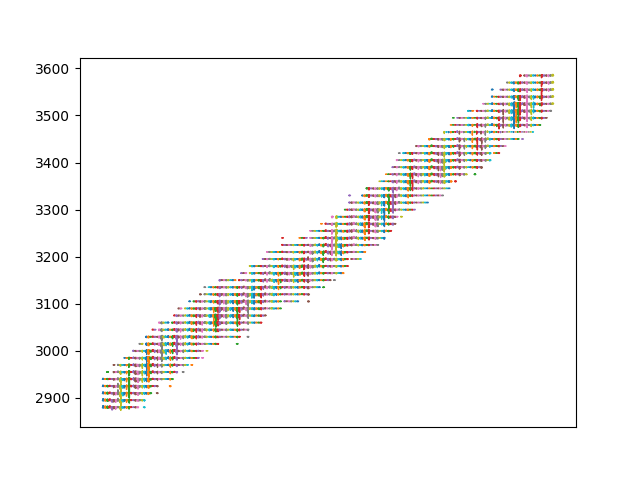

In [16]:
# iterates over each channel, plots only 
# function to plot one template (its good practice to create functions that do things we will be repeating)
def _plot_template(X,
                   offset, # offset in x
                   cmap,   # channel positions
                   srate = 30000, # for getting the waveforms in time 
                   gainx = 1.5e4, # gain of the x scale (divide the number in the axis by this to get seconds)
                   gainy = 0.03,  # gain in y, divide by this to get the input units
                   color = 'k',  
                   lw = 1,
                   spatial_extent = 75): # controls how many channels to plot around the one with the highest peak
    
    time = gainx*np.arange(X.shape[0])/srate # generate a time vector
    # find the electrode with the highest signal
    electrode = np.argmax(np.max(np.abs(X),axis = 0))
    toplot = np.linalg.norm(cmap-cmap[electrode],axis = 1)<spatial_extent

    for (x,y),t in zip(cmap[toplot],X[:,toplot].T):
        plt.plot(time+x+offset,y+t*gainy,color = color,lw = lw)

plt.figure()
colors = [plt.colormaps.get('tab10')(i) for i in range(10)] # plot each template in a differnt color
idx = np.argsort(np.argmax(np.abs(res['templates']).max(axis = 1),axis = 1)) # index to sort templates by approximate depth

for i,itemplate in enumerate(idx):  #iterate over the "sorted" templates
    # reconstruct the templates accounting for shared variance between channels (un-whitening)
    _plot_template(np.dot(res['templates'][itemplate], res['whitening_mat_inv']),
                   i*100, # offset between units
                   res['channel_positions'],
                   color = colors[np.mod(i,len(colors))])
plt.xticks([]); # x-axis is in seconds*gainx


__Plot the mean waveforms for all clusters__

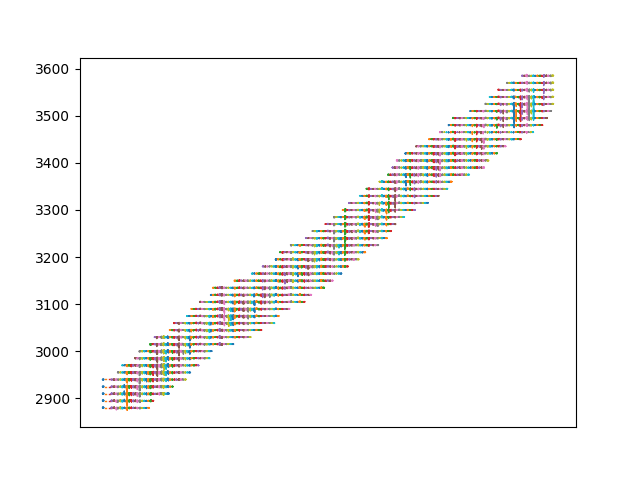

In [17]:
# plot the actual waveforms 
plt.figure()
colors = [plt.colormaps.get('tab10')(i) for i in range(10)] # plot each template in a differnt color
idx = np.argsort(np.argmax(np.abs(res['mean_waveforms']).max(axis = 2),axis=1))# index to sort templates by approximate depth

for i,itemplate in enumerate(idx):  #iterate over the "sorted" templates
    _plot_template(res['mean_waveforms'][itemplate,res['channel_indices']].T,i*100,
                    res['channel_positions'],
                    color = colors[np.mod(i,len(colors))],
                    gainx = 1e4) # adjust the gain to control the height of the samples

plt.xticks([]); # remove x ticks

Plotting the spike times versus the position in the probe is useful to assess drift correction. This is often called **drift map**.

It will be challenging to plot the drift map using all spikes so we __subsample__.



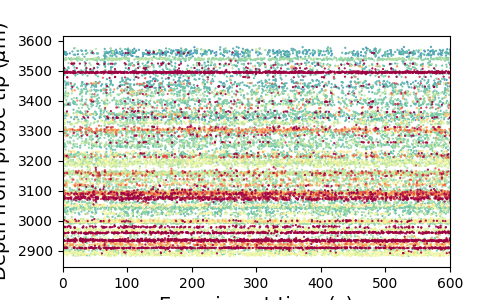

In [18]:
# use the ipympl magic so we can zoom in and out
%matplotlib ipympl
import pylab as plt
n_spikes_to_plot = 100000

# randomly subsample n_spikes_to_plot spikes
subsample = np.random.choice(np.arange(res['spike_times'].shape[0],dtype=int),n_spikes_to_plot,replace = False)
sampling_rate = 30000 # this can be read from the params.py file or from the .meta

plt.figure(figsize = [5,3])
# sort by the amplitude so the color is seen
subsample = subsample[np.argsort(res['spike_amplitudes'][subsample])]
plt.scatter(res['spike_times'][subsample]/sampling_rate,
            res['spike_positions'][subsample][:,1],
            0.3,
            res['spike_amplitudes'][subsample],
            clim=[0,10000], 
            cmap = 'Spectral_r')
plt.xlim([0,600]);
plt.ylabel('Depth from probe tip ($\mu$m)',fontsize = 14)
plt.xlabel('Experiment time (s)',fontsize = 14);


**Plot the positions of each spike**

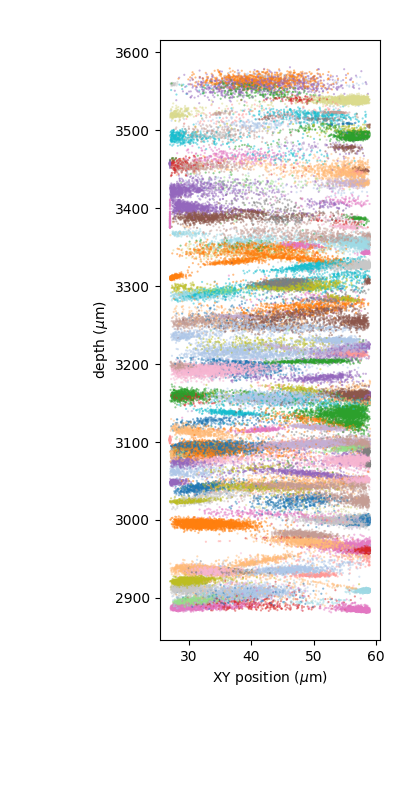

In [19]:
subsample = np.random.choice(np.arange(res['spike_times'].shape[0],dtype=int),n_spikes_to_plot,replace = False)

fig = plt.figure(figsize = [4,8])
fig.add_axes([0.4,0.2,0.55,0.75])

color_clusters = res['spike_clusters'][subsample].copy()
for c in np.unique(color_clusters): # assign a random color to each cluster
    color_clusters[res['spike_clusters'][subsample] == c] = np.random.choice(20,1)


plt.scatter(res['spike_positions'][subsample][:,0],  # X locations
            res['spike_positions'][subsample][:,1],  # Y locations
            s = 0.3,
            c = color_clusters,                      # each cluster gets a color
            cmap = 'tab20',
            alpha = 0.5)
plt.ylabel('depth ($\mu$m)')
plt.xlabel('XY position ($\mu$m)');

This is a bit messy because we included also noisy clusters.

We can use ``unit metrics`` to exclude poor quality or noisy clusters.

In [20]:
res['metrics'] # these were computed by ecephys

,cluster_id,firing_rate,presence_ratio,isi_viol,num_viol,amplitude_cutoff,isolation_distance,contam_rate,l_ratio,d_prime,...,snr,duration,halfwidth,PT_ratio,repolarization_slope,recovery_slope,amplitude,spread,velocity_above,velocity_below
0,0,1.965937,0.99,1.000000,66.0,0.000067,169.886233,1.179856,1.762131e-04,6.239919,...,1.052337,0.906533,0.357119,1.634826,0.142703,-0.036705,105.201840,135.0,1.820280,NaN
1,1,9.772643,0.99,0.291316,142.0,0.002651,NaN,0.304762,0.000000e+00,NaN,...,1.797079,0.673032,0.315913,0.308814,0.284619,-0.024681,139.605999,105.0,0.497089,0.457845
2,2,1.141873,0.99,1.000000,16.0,0.012948,133.964246,1.073593,2.229176e-05,5.621769,...,1.113315,0.892797,0.467002,0.812269,0.110702,-0.045267,113.293449,195.0,-1.312087,NaN
3,3,8.300736,0.99,0.046496,22.0,0.003920,NaN,0.070232,0.000000e+00,NaN,...,1.999682,0.604355,0.329648,0.325156,0.362604,-0.030506,162.347788,105.0,0.359735,0.000000
4,4,0.170619,0.95,1.000000,1.0,0.000773,80.261455,2.371429,3.057252e-04,5.662679,...,1.049585,0.453266,0.370854,1.249145,0.408591,-0.035224,108.938644,150.0,2.297548,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,204,0.009168,0.12,0.000000,0.0,0.014377,NaN,0.000000,0.000000e+00,NaN,...,18.777204,0.865327,0.137353,0.300541,2.820775,-0.121087,1136.906942,60.0,-0.457845,0.000000
202,205,0.339201,0.93,0.000000,0.0,0.013569,NaN,0.000000,0.000000e+00,NaN,...,5.997086,0.920268,0.233501,0.222054,0.812301,-0.079567,340.205699,75.0,0.000000,-0.915690
203,206,0.484354,0.96,0.000000,0.0,0.000272,NaN,0.000000,0.000000e+00,NaN,...,2.208927,0.851591,0.274707,0.222462,0.292050,-0.010191,118.164961,75.0,0.000000,-7.050810
204,207,0.116123,0.91,0.000000,0.0,0.001135,180.032751,0.000000,4.856381e-06,7.764384,...,1.063773,0.810385,0.329648,0.253083,0.163312,-0.016477,73.048106,225.0,0.000000,-1.023254


Here we will use a combination of criteria to discard noisy clusters:
 - ``presence ratio`` > 0.6
 - ``isi violations`` < 0.1
 - ``amplitude`` > 50 µV
 - ``amplitude cutoff`` < 0.1

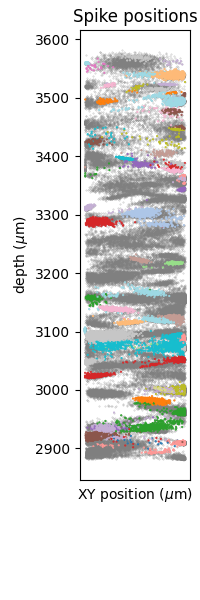

In [21]:
subsample = np.random.choice(np.arange(res['spike_times'].shape[0],dtype=int),n_spikes_to_plot,replace = False)

fig = plt.figure(figsize = [2,6])
fig.add_axes([0.4,0.2,0.55,0.75])

color_clusters = res['spike_clusters'][subsample].copy()
for c in np.unique(color_clusters): # assign a random color to each cluster
    color_clusters[res['spike_clusters'][subsample] == c] = np.random.choice(20,1)

# plot the other spikes as background
plt.scatter(res['spike_positions'][subsample][:,0],  # X locations
            res['spike_positions'][subsample][:,1],  # Y locations
            s = 0.1,
            color = 'gray', # all spikes in gray
            alpha = 0.5)
plt.ylabel('depth ($\mu$m)')
plt.xticks([]);

# Do the unit selection
selected_clusters = res['metrics'][(res['metrics']['presence_ratio'] > 0.6) & 
                                   (res['metrics']['isi_viol'] < 0.1) & 
                                   (res['metrics']['amplitude'] > 50) &
                                   (res['metrics']['amplitude_cutoff'] < 0.1)].cluster_id.values
                                   
sel = np.isin(res['spike_clusters'][subsample],selected_clusters)
plt.scatter(res['spike_positions'][subsample][sel,0],  # X locations
            res['spike_positions'][subsample][sel,1],  # Y locations
            s = 0.3,
            c = color_clusters[sel],                      # each cluster gets a color
            cmap = 'tab20',
            alpha = 1);
plt.title('Spike positions')
plt.ylabel('depth ($\mu$m)')
plt.xlabel('XY position ($\mu$m)');

The **inter-spike interval histogram** is useful to look for instance at refractory period violations or temporal dynamics.
To compute, take histogram of the difference between consecutive spikes. 

One of the metrics estimates false positives (see [Hill et al. 2011](https://www.jneurosci.org/content/31/24/8699.long)) that is closely related to the violations in the refractory period. 


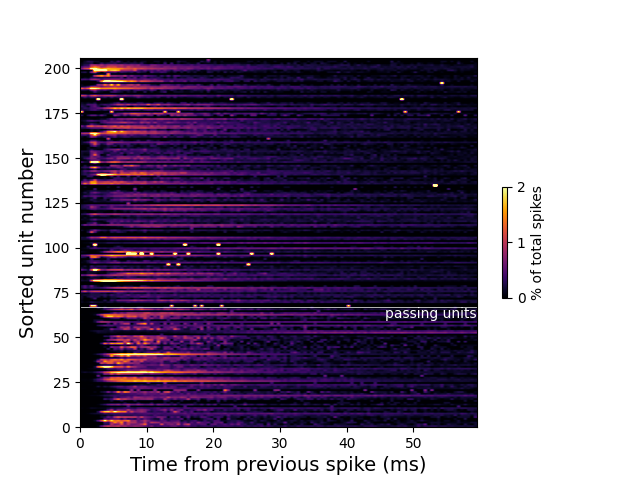

In [ ]:
# plot inter-spike interval (ISI) histograms for all cells 

unit_spiketimes = [res['spike_times'][np.isin(res['spike_clusters'],[uclu])]/sampling_rate for uclu in np.unique(res['spike_clusters'])]

binsize = 0.0005 # in seconds
isi_histogram_edges = np.arange(0,0.06,binsize) # range of the interspike interval 
# histogram of the difference between consecutive spikes
isi_histograms = [np.histogram(np.diff(u),bins=isi_histogram_edges)[0] for u in unit_spiketimes] 
# normalize to the total number of spikes?
isi_histograms_norm = np.stack([isi_histogram/len(unit_spikes) for isi_histogram,unit_spikes in zip(isi_histograms,unit_spiketimes)])

%matplotlib ipympl
passing = ((res['metrics']['presence_ratio'] > 0.6) & 
                                   (res['metrics']['isi_viol'] < 0.1) & 
                                   (res['metrics']['amplitude'] > 50) &
                                   (res['metrics']['amplitude_cutoff'] < 0.1)).values

plt.figure()
# have a dictionary with all the plot parameters so we have the same settings
plot_parameters = dict(clim = [0,2],
                       aspect = 'auto',
                       cmap = 'inferno',
                       extent = [isi_histogram_edges[0]*1000,isi_histogram_edges[-1]*1000,0,len(isi_histograms_norm)])
# sort by whether the unit passes or not
idx = np.argsort(passing) 
plt.imshow(100*isi_histograms_norm[idx],**plot_parameters)
plt.hlines(np.sum(passing),0,isi_histogram_edges[-1]*1000,color = 'w',lw = 0.5)
plt.text(isi_histogram_edges[-1]*1000,np.sum(passing),'passing units',
         ha = 'right',
         color = 'w',
         va='top')

plt.colorbar(shrink = 0.3,label = '% of total spikes')ß
plt.ylabel('Sorted unit number',fontsize = 14)
plt.xlabel('Time from previous spike (ms)',fontsize = 14);
